<a href="https://colab.research.google.com/github/ydecoster/Deep_Learning_ENSAE_2022/blob/main/notebook_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---
<h1><center><strong><font color="chillipepper">Deep Learning - ENSAE 2022</font></strong></center></h1>
<h2><center><strong><font color="chillipepper">Score-based generative modeling through stochastic differential
equations</font></strong></center></h2>

---

Yann DE COSTER (yann.decoster@ensae.fr) et Rémi VIDAL (remi.vidal@ensae.fr)

Au travers de ce notebook nous mettons en application les méthodes de score-based generative modeling développée dans [ce papier](https://arxiv.org/pdf/2011.13456.pdf). Nous appliquons ce type de modèles pour générer de nouveaux échatillons d'images, à la manière des GANs. Les datasets utilisés seront toutefois différents de ceux utilisés dans l'article. Enfin, nous quantifierons nos résultats avec des scores appropriés.

# Imports et installations

## Packages

In [1]:
!pip install functools natsort torchvision

  ERROR: Failed building wheel for functools
  Running setup.py clean for functools
Failed to build functools
    Running setup.py install for functools ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-basydsvp/functools_1fcf46504af2419e8ec5b86b8e449955/setup.py'"'"'; __file__='"'"'/tmp/pip-install-basydsvp/functools_1fcf46504af2419e8ec5b86b8e449955/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-36v8xkms/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/functools Check the logs for full command output.


In [2]:
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py

--2022-05-01 08:51:43--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2022-05-01 08:51:43 (13.5 MB/s) - ‘helper.py’ saved [2813/2813]



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import functools
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import tqdm

import os
import natsort
from PIL import *
import PIL.Image
import helper
import matplotlib.pyplot as plt

from scipy import integrate

## Données

Après avoir testé les modèles sur la base Fashion MNIST, nous pensions qu'il serait plus intéressant de tester sur une base plus éloignée que MNIST, qui est utilisée dans le notebook des auteurs. Nous avons donc choisi la base de données [Cars](https://ai.stanford.edu/~jkrause/cars/car_dataset.html), qui recense plus de 16 000 images de voitures.

In [6]:
! wget -c http://ai.stanford.edu/~jkrause/car196/cars_train.tgz

--2022-05-01 08:52:05--  http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  55.7MB/s    in 18s     

2022-05-01 08:52:23 (51.9 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



In [7]:
# Extraction
import tarfile
tar = tarfile.open('cars_train.tgz', "r:gz")
tar.extractall()
tar.close()

In [8]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


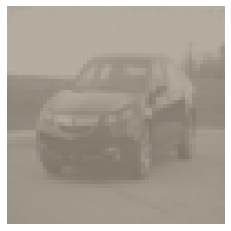

In [10]:
# Mise en forme des données

data_dir = 'cars_train'
batch_size =  32 #@param {'type':'integer'}

transform = transforms.Compose([transforms.Resize([60, 60]),
                                transforms.Grayscale(1),
                                transforms.ToTensor()])
dataset = CustomDataSet(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

image = next(iter(dataloader))
helper.imshow(image[0,:])
plt.show()

In [11]:
from torchvision.datasets import FashionMNIST

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


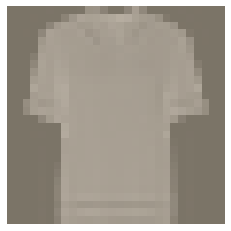

In [12]:
batch_size =  32 #@param {'type':'integer'}

dataset = FashionMNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

image, label = next(iter(data_loader))
helper.imshow(image[0,:])
plt.show()

# Définition du score-based model

In [29]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[64, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

# Définition de l'équation différentielle stochastique

In [30]:
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

# Définition de la fonction de perte

In [31]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [32]:
device

'cuda'

# Entraînement du modèle

In [33]:
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   300#@param {'type':'integer'}
## size of a mini-batch
batch_size =  32 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

# dataset = FashionMNIST('.', train=True, transform=transforms.ToTensor(), download=True)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# optimizer = Adam(score_model.parameters(), lr=lr)
# tqdm_epoch = tqdm.notebook.trange(n_epochs)
# for epoch in tqdm_epoch:
#   avg_loss = 0.
#   num_items = 0
#   for x, y in data_loader:
#     x = x.to(device)    
#     loss = loss_fn(score_model, x, marginal_prob_std_fn)
#     optimizer.zero_grad()
#     loss.backward()    
#     optimizer.step()
#     avg_loss += loss.item() * x.shape[0]
#     num_items += x.shape[0]
#   # Print the averaged training loss so far.
#   tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
#   # Update the checkpoint after each epoch of training.
#   torch.save(score_model.state_dict(), 'ckpt.pth')

In [34]:
# Checkpoint de Fashion_MNIST : 
# !wget "https://github.com/ydecoster/Deep_Learning_ENSAE_2022/raw/main/ckpt_fashion.pth"

# Checkpoint de Cars : 
!wget "https://github.com/ydecoster/Deep_Learning_ENSAE_2022/raw/main/ckpt_cars_300ep_60px.pth"

--2022-05-01 09:06:24--  https://github.com/ydecoster/Deep_Learning_ENSAE_2022/raw/main/ckpt_cars_300ep_60px.pth
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ydecoster/Deep_Learning_ENSAE_2022/main/ckpt_cars_300ep_60px.pth [following]
--2022-05-01 09:06:24--  https://raw.githubusercontent.com/ydecoster/Deep_Learning_ENSAE_2022/main/ckpt_cars_300ep_60px.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4765613 (4.5M) [application/octet-stream]
Saving to: ‘ckpt_cars_300ep_60px.pth.1’

ckpt_cars_300ep_60p 100%[===================>]   4.54M  --.-KB/s    in 0.07s   

2022-05-01 09:06:25 (61.8 MB

In [35]:
score_model.load_state_dict(torch.load("ckpt_cars_300ep_60px.pth"))

<All keys matched successfully>

# Définition du Euler-Maruyama sampler

In [36]:
## The number of sampling steps.
num_steps =  100#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 60, 60, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

# Définition du Predictor-Corrector sampler

In [37]:
signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  100#@param {'type':'integer'}
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               eps=1e-3):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns: 
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 60, 60, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

# Définition du ODE sampler

In [38]:
## The error tolerance for the black-box ODE solver
error_tolerance = 1e-2 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cuda', 
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation 
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, 60, 60, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z
    
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t    
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

# Sampling

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


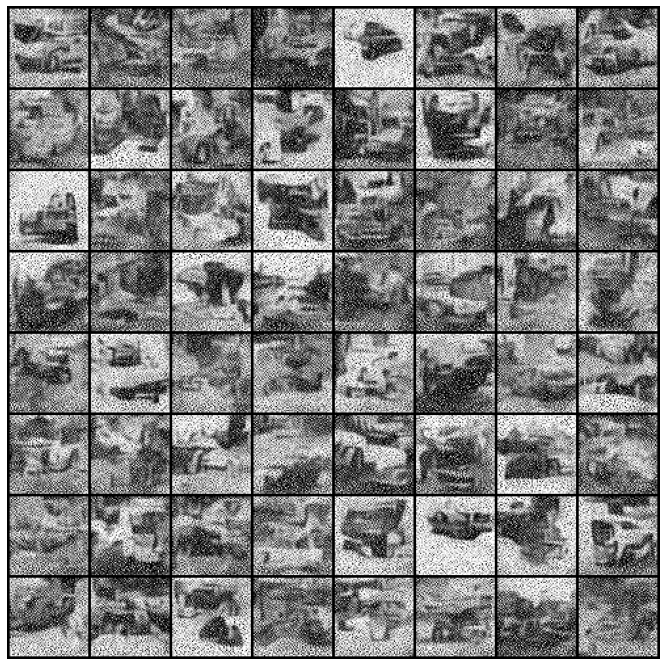

In [40]:
from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

# ckpt = torch.load('ckpt_fashion.pth', map_location=device)
ckpt = torch.load('ckpt_cars_300ep_60px.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = pc_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

# Inception Score

In [55]:
samples[0][0]

tensor([[0.7966, 0.7388, 0.4505,  ..., 0.0396, 0.4495, 0.6582],
        [1.0000, 0.4335, 0.9681,  ..., 0.4291, 0.3175, 0.5646],
        [0.5449, 0.8478, 0.3401,  ..., 0.9639, 0.7656, 0.4150],
        ...,
        [0.1713, 0.9918, 0.5239,  ..., 0.9652, 0.8683, 0.6064],
        [0.6253, 0.3218, 0.5670,  ..., 0.5418, 0.7923, 0.8282],
        [0.4791, 0.7845, 0.4952,  ..., 0.8194, 0.7953, 0.7983]],
       device='cuda:0')

In [43]:
!wget "https://raw.githubusercontent.com/sbarratt/inception-score-pytorch/master/inception_score.py"

--2022-05-01 09:12:05--  https://raw.githubusercontent.com/sbarratt/inception-score-pytorch/master/inception_score.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2990 (2.9K) [text/plain]
Saving to: ‘inception_score.py’

inception_score.py  100%[===================>]   2.92K  --.-KB/s    in 0s      

2022-05-01 09:12:05 (29.4 MB/s) - ‘inception_score.py’ saved [2990/2990]



In [46]:
from inception_score import inception_score

In [59]:
inception_score(samples, cuda=True, batch_size=32, resize=False, splits=1)

RuntimeError: ignored